In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.apps.nuclick.transforms import AddClickSignalsd, PostFilterLabeld
from monai.apps.utils import download_and_extract
from monai.bundle import download
from monai.config import print_config
from monai.data import PILReader
from monai.networks.nets import BasicUNet
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    ScaleIntensityRangeD,
    SqueezeDimd,
)
from monai.utils import convert_to_numpy

print_config()



MONAI version: 1.2.0
Numpy version: 1.24.4
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: N

In [2]:


workspace_path = os.path.normpath("workspace/")
max_epochs = 1

bundle_name = "pathology_nuclick_annotation"

bundle_path = os.path.join(workspace_path, bundle_name)
if not os.path.exists(bundle_path):
    download(name=bundle_name, bundle_dir=workspace_path)

model_weights_path = os.path.join(bundle_path, "models", "model.pt")

In [3]:
device = torch.device("cpu")
network = BasicUNet(spatial_dims=2, in_channels=5, out_channels=1, features=(32, 64, 128, 256, 512, 32))

checkpoint = torch.load(model_weights_path, map_location=torch.device(device))
model_state_dict = checkpoint.get("model", checkpoint)
network.load_state_dict(model_state_dict, strict=True)

BasicUNet features: (32, 64, 128, 256, 512, 32).


<All keys matched successfully>

Image: torch.Size([1000, 1000, 3])
Foreground Points: [[190, 15], [218, 32], [296, 96]]


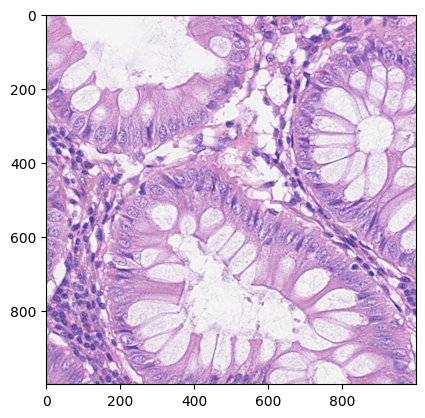

In [4]:
image_file = os.path.join('./workspace','test_12.png')
foreground = [[190, 15], [218, 32], [296, 96]]
reader = PILReader(converter=lambda im: im.convert("RGB"))
image_np = LoadImage(image_only=True, dtype=np.uint8, reader=reader)(image_file)

print(f"Image: {image_np.shape}\nForeground Points: {foreground}")
plt.imshow(image_np)

In [5]:
# Transforms
from monai.transforms import Compose
pre_transforms = Compose([
    LoadImaged(keys="image", dtype=np.uint8, reader=PILReader(converter=lambda im: im.convert("RGB"))),
    EnsureChannelFirstd(keys="image"),
    ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
    AddClickSignalsd(image="image", foreground="foreground", gaussian=False),
])

data = {"image": image_file, "foreground": foreground}

data = pre_transforms(data)

/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [46]:
data["image"].shape, type(data["image"]), type(foreground)

(torch.Size([3, 5, 128, 128]), monai.data.meta_tensor.MetaTensor, list)

In [7]:
#prediction
network.eval()
with torch.no_grad():
    pred = network(data["image"])

In [8]:
# Transforms
post_transforms = Compose([
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5, dtype=np.uint8),
    SqueezeDimd(keys="pred", dim=1),
    PostFilterLabeld(keys="pred"),
])

data["pred"] = pred
output_predictions = post_transforms(data)


In [16]:
np.max(output_predictions["pred"])

1

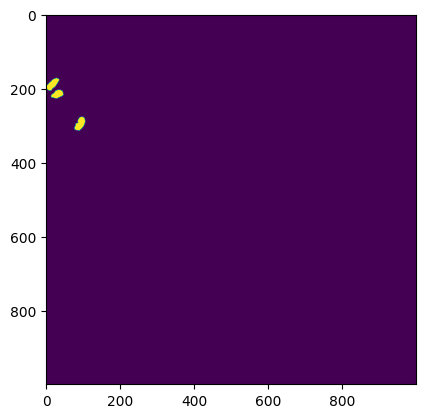

In [10]:
plt.imshow(output_predictions["pred"][:,:])

In [22]:
#generating the boundary boxes
from skimage.measure import regionprops, label

nuclei_obj_props = regionprops(label(output_predictions["pred"]))

In [23]:
print(len(nuclei_obj_props))

3


In [41]:
nuclei_annot_list=[]

for i in range(len(nuclei_obj_props)):
    cx = nuclei_obj_props[i].centroid[1]
    cy = nuclei_obj_props[i].centroid[0]
    width = nuclei_obj_props[i].bbox[3] - nuclei_obj_props[i].bbox[1] + 1
    height = nuclei_obj_props[i].bbox[2] - nuclei_obj_props[i].bbox[0] + 1
    print(cx,cy, width, height)

    cur_bbox = {
    'type': 'rectangle',
    'center': [cx, cy, 0],
    'width': width,
    'height': height,
    'rotation': 0,
    'fillColor': 'rgba(0,0,0,0)',
    'lineColor': 'rgb(0,255,0)'
}

    nuclei_annot_list.append(cur_bbox)

17.226917057902973 189.3223787167449 36 35
30.669187145557657 216.2797731568998 35 24
91.81739130434782 296.38260869565215 30 38


In [42]:
len(nuclei_annot_list)

3

In [43]:
#Testing the ai model .py file

In [44]:
from aiInferenceModel.nuclickSegmentation import run_ai_model_inferencing

payload = {"image":image_np, "foreground":foreground}

output = run_ai_model_inferencing(payload)

ModuleNotFoundError: No module named 'aiInferenceModel'